In [1]:
import ee
import geemap


In [2]:
ee.Initialize()

In [3]:
aoi = ee.Geometry.Polygon(
    [
        [-77.4467, 44.1024],
        [-77.4467, 44.2352],
        [-77.2686, 44.2352],
        [-77.2686, 44.1024],
        [-77.4467, 44.1024],
    ]
)

START = '2017-04-01'
END = '2017-10-31'

# DATES = [(f'{year}-04-01', f'{year}-10-31') for year in range(2017, 2024)]



In [4]:
from geeopca import rsd


s2_toa = rsd.Sentinel2TOA(aoi=aoi, start=START, end=END)

In [5]:
s2_toa.rsd.first()

In [6]:
df = s2_toa.to_dataframe()
df.head()


,geometry,syspath,utc,x,y,timezone,timestamp,year,julian_date
0,"POLYGON ((-77.44500 44.22733, -77.44502 44.227...",COPERNICUS/S2_HARMONIZED/20170611T161351_20170...,1.497198e+09,-77.482410,44.181806,America/Toronto,2017-06-11 12:13:45.460000038-04:00,2017,162
1,"POLYGON ((-77.48083 44.13854, -77.48077 44.138...",COPERNICUS/S2_HARMONIZED/20170611T161351_20170...,1.497198e+09,-77.372628,44.786364,America/Toronto,2017-06-11 12:13:45.460000038-04:00,2017,162
2,"POLYGON ((-77.50419 44.22598, -77.50420 44.225...",COPERNICUS/S2_HARMONIZED/20170621T161341_20170...,1.498062e+09,-77.479250,44.175426,America/Toronto,2017-06-21 12:15:17.259999990-04:00,2017,172
3,"POLYGON ((-77.43574 44.22753, -77.43577 44.227...",COPERNICUS/S2_HARMONIZED/20170701T161341_20170...,1.498926e+09,-77.478795,44.174386,America/Toronto,2017-07-01 12:14:54.609999895-04:00,2017,182
4,"POLYGON ((-77.51674 44.52233, -77.51686 44.522...",COPERNICUS/S2_HARMONIZED/20170721T161351_20170...,1.500654e+09,-77.453202,44.369485,America/Toronto,2017-07-21 12:20:51.180000067-04:00,2017,202


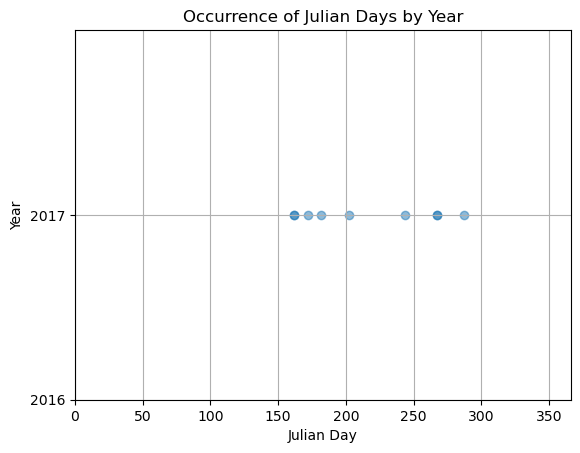

In [7]:
from geeopca import plots

plot = plots.date_time_scatter_plot(df)
